<a href="https://colab.research.google.com/github/Salsabilaurelia1408/tugasakhirsalsa/blob/main/FIX_WGPR_Optimum_FIX_Relu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


            Date    WOPR  WWPR   WGPR  GOR   WBHP
Time                                             
5     2015-07-06  1314.0   0.0  0.240  183  323.0
6     2015-07-07  1321.0   0.0  0.260  197  335.0
7     2015-07-08  1309.0   0.0  0.247  189  343.0
8     2015-07-09  1299.0   0.0  0.233  179  348.0
9     2015-07-10  1287.0   0.0  0.240  186  349.0
...          ...     ...   ...    ...  ...    ...
686   2017-05-17   501.2  13.1  0.315  628  239.0
687   2017-05-18   501.3  12.4  0.313  624  240.0
688   2017-05-19   500.2  12.5  0.314  628  239.0
689   2017-05-20   503.1  11.5  0.311  618  241.0
690   2017-05-21   503.1  11.5  0.311  618  241.0

[629 rows x 6 columns]


<Axes: xlabel='Time'>

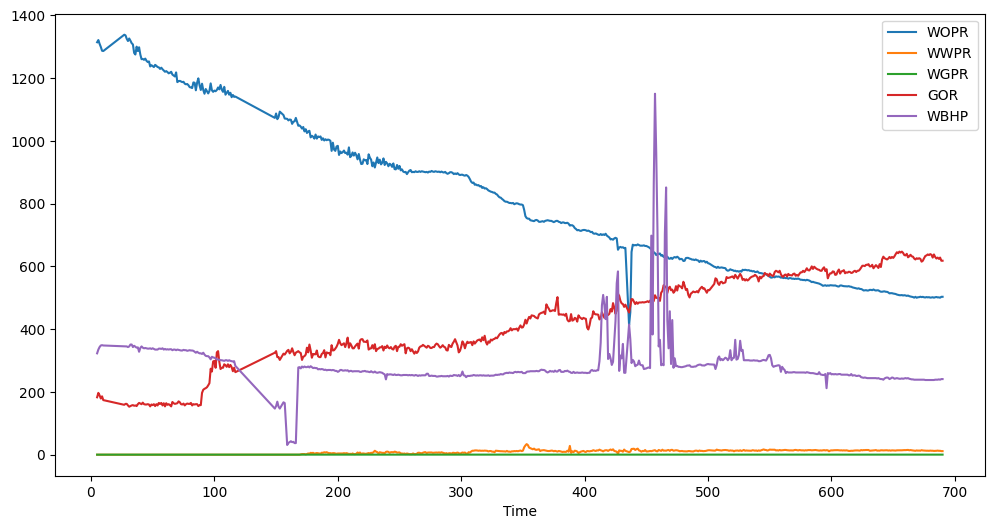

In [2]:
# Load data
url ='https://raw.githubusercontent.com/Salsabilaurelia1408/tugasakhirsalsa/main/WOPR2_DateFormatRevised.csv'

df = pd.read_csv(url, index_col='Time', parse_dates=True)
'''
df.set_index('Date', inplace=True)
df.index.freq ='MS'
'''

print(df)

df.plot(figsize=(12,6))


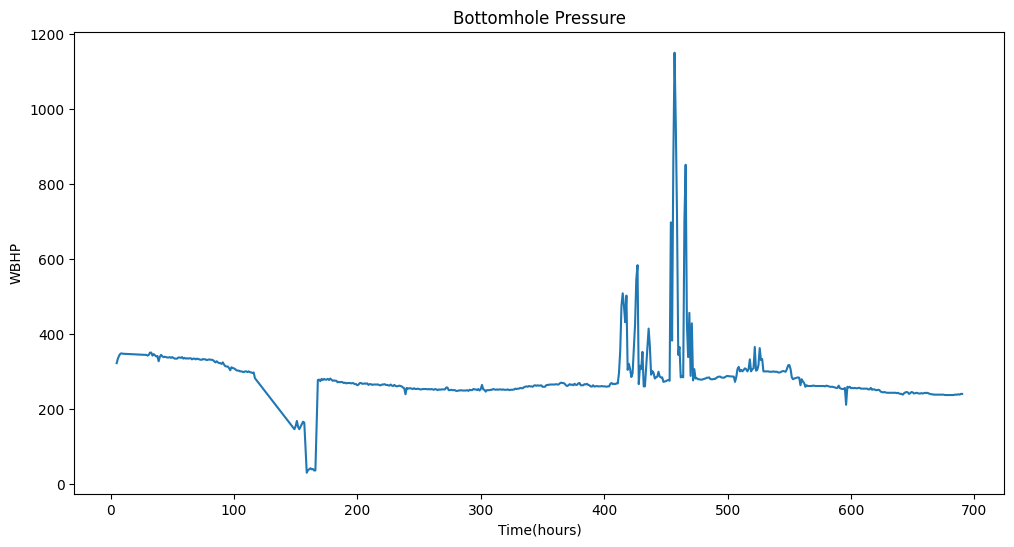

In [3]:
df['WBHP'].plot(x='Time', y='WBHP', figsize=(12, 6))
plt.title('Bottomhole Pressure')
plt.xlabel('Time(hours)')
plt.ylabel('WBHP')
plt.show()


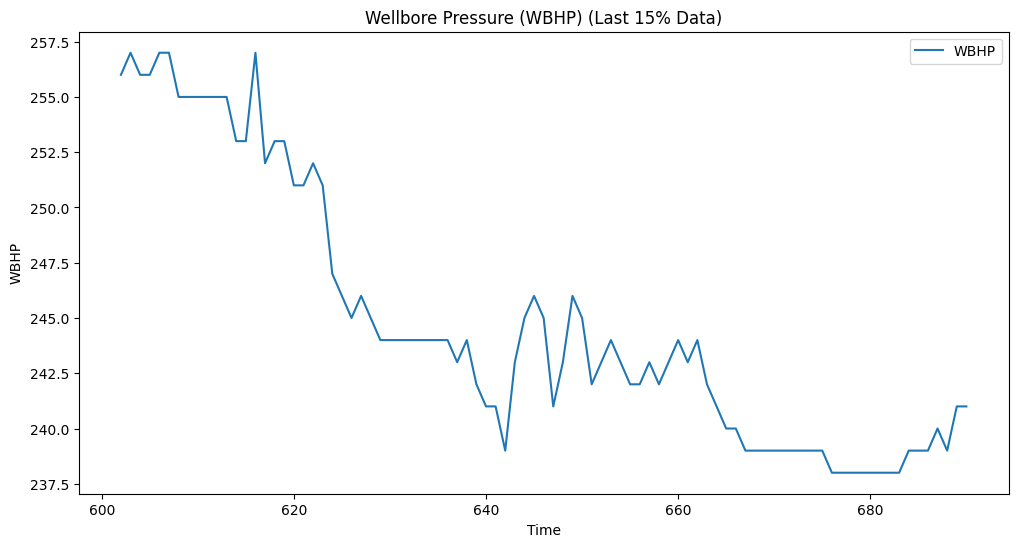

In [4]:
df = pd.read_csv(url, index_col='Time', parse_dates=True)
start_index = int(len(df) * 0.86)
end_index = len(df)
subset_df = df.iloc[start_index:end_index][['WBHP']]
subset_df.plot(figsize=(12, 6))
plt.title('Wellbore Pressure (WBHP) (Last 15% Data)')
plt.xlabel('Time')
plt.ylabel('WBHP')
plt.show()


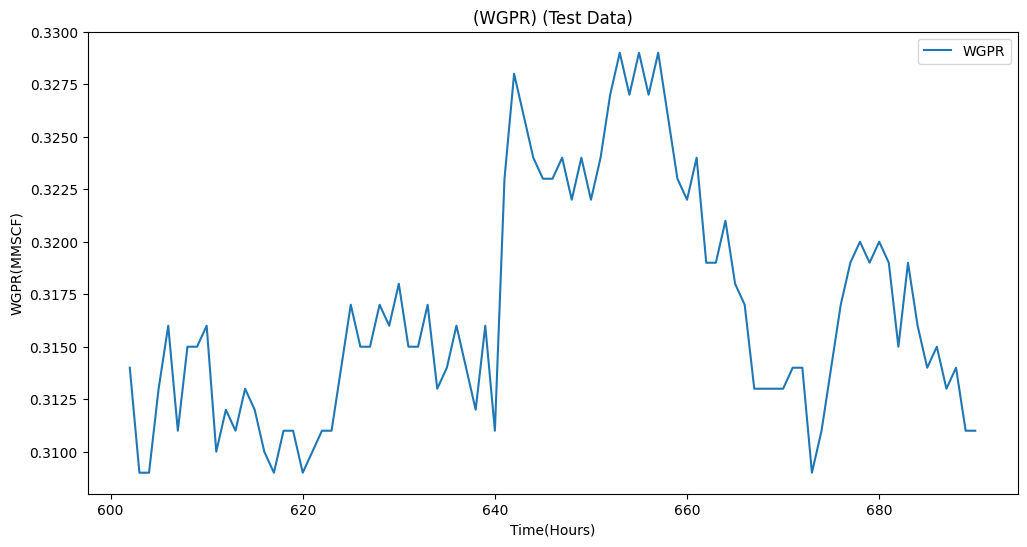

In [5]:
df = pd.read_csv(url, index_col='Time', parse_dates=True)
start_index = int(len(df) * 0.86)
end_index = len(df)
subset_df = df.iloc[start_index:end_index][['WGPR']]
subset_df.plot(figsize=(12, 6))
plt.title('(WGPR) (Test Data)')
plt.xlabel('Time(Hours)')
plt.ylabel('WGPR(MMSCF)')
plt.show()


In [6]:
# Define input and output variables
X = df[['WBHP','WOPR','GOR','WWPR']]
Y = df['WGPR']



In [7]:
def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
    plt.plot(history.history['val_loss'], label='Dev Loss', linewidth=3)
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title('Loss - ' + title, fontsize=15)
    plt.xlim(0, len(history.history['loss']))
    plt.ylim(0, max(history.history['val_loss']))
    plt.show()


# Reshape data to fit the input shape of the models
def reshape_data(X,Y, look_back=1):
    dataX = []
    dataY = []
    '''
    for i in range(look_back, len(Data)):
        X.append(data[i-look_back:i, :])
        Y.append(data[i, 0])
    '''
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        b = Y[i + look_back, :]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)
    

test_fraction = 0.15
X_traindev_raw, X_test_raw, Y_traindev_raw, Y_test_raw = train_test_split(X, Y, test_size=test_fraction, shuffle=False)
dev_fraction = 0.15
X_train_raw, X_dev_raw, Y_train_raw, Y_dev_raw = train_test_split(X_traindev_raw, Y_traindev_raw, test_size=dev_fraction/(1-test_fraction), shuffle=False)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_raw)
X_dev_scaled = scaler.fit_transform(X_dev_raw)
X_test_scaled = scaler.fit_transform(X_test_raw)

Y_train_scaled = scaler.fit_transform(np.array(Y_train_raw).reshape(-1,1))
Y_dev_scaled = scaler.fit_transform(np.array(Y_dev_raw).reshape(-1,1))
Y_test_scaled = scaler.fit_transform(np.array(Y_test_raw).reshape(-1,1))

X_train, Y_train = reshape_data(X_train_scaled, Y_train_scaled, look_back=10)
X_dev, Y_dev = reshape_data(X_dev_scaled, Y_dev_scaled, look_back=10)
X_test, Y_test = reshape_data(X_test_scaled, Y_test_scaled, look_back=10)

# Define LSTM model
model_LSTM = Sequential()
model_LSTM.add(LSTM(512, activation='relu', input_shape=(10, 4)))
model_LSTM.add(Dense(1))
model_LSTM.add(Dropout(0.2))
model_LSTM.compile(optimizer='adam', loss='mean_squared_error', metrics =['mae', 'accuracy'])

# Define GRU model
model_GRU = Sequential()
model_GRU.add(GRU(512, activation='relu', input_shape=(10, 4)))
model_GRU.add(Dense(1))
model_GRU.add(Dropout(0.2))
model_GRU.compile(optimizer='adam', loss='mean_squared_error', metrics =['mae', 'accuracy'])

# Define Vanilla RNN model
model_Vanilla = Sequential()
model_Vanilla.add(SimpleRNN(512, activation='relu', input_shape=(10, 4)))
model_Vanilla.add(Dense(1))
model_Vanilla.add(Dropout(0.2))
model_Vanilla.compile(optimizer='adam', loss='mean_squared_error', metrics =['mae', 'accuracy'])

# Train the models
history_LSTM = model_LSTM.fit(X_train, Y_train, epochs=50, batch_size=100, validation_data=(X_dev, Y_dev), verbose=1, shuffle = False)
history_GRU = model_GRU.fit(X_train, Y_train, epochs=50, batch_size =100, validation_data=(X_dev, Y_dev), verbose=1, shuffle = False)
history_Vanilla = model_Vanilla.fit(X_train, Y_train, epochs=50, batch_size=100, validation_data=(X_dev, Y_dev), verbose=1, shuffle = False)

'''
# Predict using the models
Y_pred_LSTM = model_LSTM.predict(X_test)
Y_pred_GRU = model_GRU.predict(X_test)
Y_pred_Vanilla = model_Vanilla.predict(X_test)

# Reshape predicted and actual values
Y_pred_LSTM = scaler.inverse_transform(Y_pred_LSTM.reshape(-1, 1))
Y_pred_GRU = scaler.inverse_transform(Y_pred_GRU.reshape(-1, 1))
Y_pred_Vanilla = scaler.inverse_transform(Y_pred_Vanilla.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

'''

Epoch 1/50
5/5 [==============================] - 9s 909ms/step - loss: 0.2271 - mae: 0.4212 - accuracy: 0.0023 - val_loss: 0.0590 - val_mae: 0.1968 - val_accuracy: 0.0118
Epoch 2/50
5/5 [==============================] - 3s 560ms/step - loss: 0.1363 - mae: 0.2834 - accuracy: 0.0023 - val_loss: 0.0541 - val_mae: 0.1880 - val_accuracy: 0.0118
Epoch 3/50
5/5 [==============================] - 2s 426ms/step - loss: 0.1226 - mae: 0.2832 - accuracy: 0.0047 - val_loss: 0.0576 - val_mae: 0.2011 - val_accuracy: 0.0118
Epoch 4/50
5/5 [==============================] - 2s 437ms/step - loss: 0.1324 - mae: 0.3049 - accuracy: 0.0023 - val_loss: 0.0513 - val_mae: 0.1907 - val_accuracy: 0.0118
Epoch 5/50
5/5 [==============================] - 1s 256ms/step - loss: 0.1037 - mae: 0.2359 - accuracy: 0.0023 - val_loss: 0.0596 - val_mae: 0.1978 - val_accuracy: 0.0118
Epoch 6/50
5/5 [==============================] - 1s 200ms/step - loss: 0.1115 - mae: 0.2404 - accuracy: 0.0047 - val_loss: 0.0668 - val_mae

'\n# Predict using the models\nY_pred_LSTM = model_LSTM.predict(X_test)\nY_pred_GRU = model_GRU.predict(X_test)\nY_pred_Vanilla = model_Vanilla.predict(X_test)\n\n# Reshape predicted and actual values\nY_pred_LSTM = scaler.inverse_transform(Y_pred_LSTM.reshape(-1, 1))\nY_pred_GRU = scaler.inverse_transform(Y_pred_GRU.reshape(-1, 1))\nY_pred_Vanilla = scaler.inverse_transform(Y_pred_Vanilla.reshape(-1, 1))\nY_test = scaler.inverse_transform(Y_test.reshape(-1, 1))\n\n'

**LSTM**

In [8]:

# Predict using the model
Y_pred_train = model_LSTM.predict(X_train)
Y_pred_dev = model_LSTM.predict(X_dev)
Y_pred_test = model_LSTM.predict(X_test)


# Reshape predicted and actual values
Y_pred_train_LSTM = scaler.inverse_transform(Y_pred_train.reshape(-1, 1))
Y_pred_dev_LSTM = scaler.inverse_transform(Y_pred_dev.reshape(-1, 1))
Y_pred_test_LSTM = scaler.inverse_transform(Y_pred_test.reshape(-1, 1))


Y_train_act = scaler.inverse_transform(Y_train.reshape(-1,1))
Y_dev_act = scaler.inverse_transform(Y_dev.reshape(-1,1))
Y_test_act = scaler.inverse_transform(Y_test.reshape(-1,1))


3/3 [==============================] - 0s 21ms/step


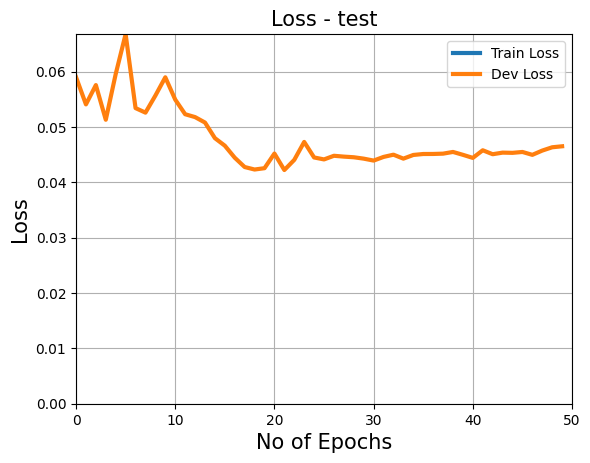

Training Set Score: 0.5389
Dev Set Score: 0.0953
Test Set Score: 0.1618
Training Set MSE: 0.0000
Dev Set MSE: 0.0000
Test Set MSE: 0.0000


In [9]:
plot_loss(history_LSTM, title='test')
train_mse, train_acc = mean_squared_error(Y_train_act, Y_pred_train_LSTM), r2_score(Y_train_act, Y_pred_train_LSTM)
dev_mse, dev_acc = mean_squared_error(Y_dev_act, Y_pred_dev_LSTM), r2_score(Y_dev_act, Y_pred_dev_LSTM)
test_mse, test_acc = mean_squared_error(Y_test_act, Y_pred_test_LSTM), r2_score(Y_test_act, Y_pred_test_LSTM)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

**GRU**

In [10]:
# Predict using the model
Y_pred_train = model_GRU.predict(X_train)
Y_pred_dev = model_GRU.predict(X_dev)
Y_pred_test = model_GRU.predict(X_test)


# Reshape predicted and actual values
Y_pred_train_GRU = scaler.inverse_transform(Y_pred_train.reshape(-1, 1))
Y_pred_dev_GRU = scaler.inverse_transform(Y_pred_dev.reshape(-1, 1))
Y_pred_test_GRU = scaler.inverse_transform(Y_pred_test.reshape(-1, 1))


Y_train_act = scaler.inverse_transform(Y_train.reshape(-1,1))
Y_dev_act = scaler.inverse_transform(Y_dev.reshape(-1,1))
Y_test_act = scaler.inverse_transform(Y_test.reshape(-1,1))

3/3 [==============================] - 0s 20ms/step


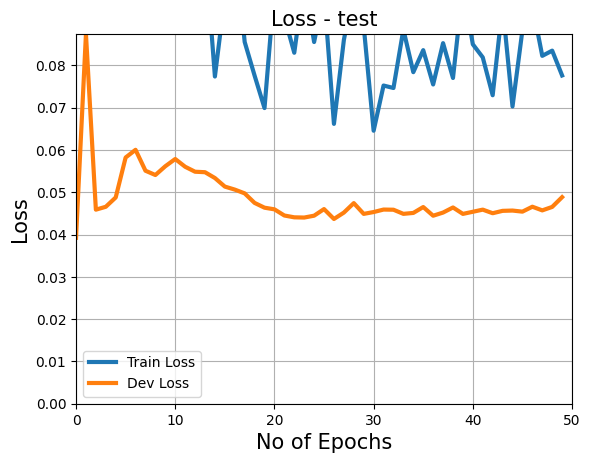

Training Set Score: -1623.8181
Dev Set Score: -1857.9577
Test Set Score: -1452.7394
Training Set MSE: 0.0574
Dev Set MSE: 0.0646
Test Set MSE: 0.0434


In [11]:
plot_loss(history_GRU, title='test')
train_mse, train_acc = mean_squared_error(Y_train_act, Y_pred_train), r2_score(Y_train_act, Y_pred_train)
dev_mse, dev_acc = mean_squared_error(Y_dev_act, Y_pred_dev), r2_score(Y_dev_act, Y_pred_dev)
test_mse, test_acc = mean_squared_error(Y_test_act, Y_pred_test), r2_score(Y_test_act, Y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

**Vanilla RNN**

In [12]:
# Predict using the model
Y_pred_train = model_Vanilla.predict(X_train)
Y_pred_dev = model_Vanilla.predict(X_dev)
Y_pred_test = model_Vanilla.predict(X_test)


# Reshape predicted and actual values
Y_pred_train_RNN = scaler.inverse_transform(Y_pred_train.reshape(-1, 1))
Y_pred_dev_RNN = scaler.inverse_transform(Y_pred_dev.reshape(-1, 1))
Y_pred_test_RNN = scaler.inverse_transform(Y_pred_test.reshape(-1, 1))


Y_train_act = scaler.inverse_transform(Y_train.reshape(-1,1))
Y_dev_act = scaler.inverse_transform(Y_dev.reshape(-1,1))
Y_test_act = scaler.inverse_transform(Y_test.reshape(-1,1))

3/3 [==============================] - 0s 10ms/step


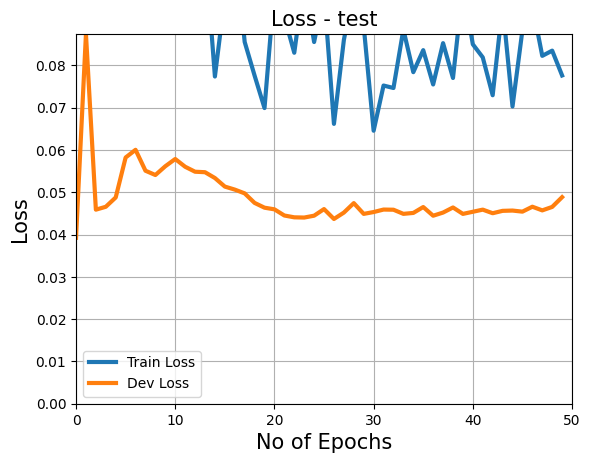

Training Set Score: -1564.0173
Dev Set Score: -1764.3311
Test Set Score: -1246.6484
Training Set MSE: 0.0553
Dev Set MSE: 0.0614
Test Set MSE: 0.0372


In [13]:
plot_loss(history_GRU, title='test')
train_mse, train_acc = mean_squared_error(Y_train_act, Y_pred_train), r2_score(Y_train_act, Y_pred_train)
dev_mse, dev_acc = mean_squared_error(Y_dev_act, Y_pred_dev), r2_score(Y_dev_act, Y_pred_dev)
test_mse, test_acc = mean_squared_error(Y_test_act, Y_pred_test), r2_score(Y_test_act, Y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

LSTM Model Loss: [0.03697963058948517, 0.1586623191833496, 0.03529411926865578]
GRU Model Loss: [0.026417048647999763, 0.13052447140216827, 0.03529411926865578]
Vanilla RNN Model Loss: [0.03122241608798504, 0.14169879257678986, 0.03529411926865578]
LSTM Model Loss_val: [0.04652047157287598, 0.1778295785188675, 0.0117647061124444]
GRU Model Loss_val: [0.04883456602692604, 0.18248575925827026, 0.0117647061124444]
Vanilla RNN Model Loss_val: [0.044508591294288635, 0.17467159032821655, 0.0117647061124444]


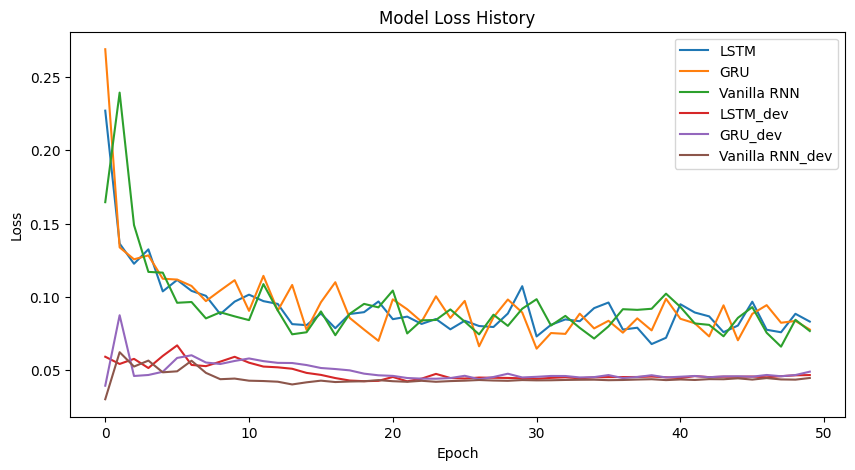

In [14]:
# Evaluate the models
loss_LSTM = model_LSTM.evaluate(X_test, Y_test, verbose=0)
loss_GRU = model_GRU.evaluate(X_test, Y_test, verbose=0)
loss_Vanilla = model_Vanilla.evaluate(X_test, Y_test, verbose=0)
loss_LSTM_val = model_LSTM.evaluate(X_dev, Y_dev, verbose=0)
loss_GRU_val = model_GRU.evaluate(X_dev, Y_dev, verbose=0)
loss_Vanilla_val = model_Vanilla.evaluate(X_dev, Y_dev, verbose=0)

print('LSTM Model Loss:', loss_LSTM)
print('GRU Model Loss:', loss_GRU)
print('Vanilla RNN Model Loss:', loss_Vanilla)
print('LSTM Model Loss_val:', loss_LSTM_val)
print('GRU Model Loss_val:', loss_GRU_val)
print('Vanilla RNN Model Loss_val:', loss_Vanilla_val)

# Plot the loss history of each model
plt.figure(figsize=(10,5))
plt.plot(history_LSTM.history['loss'], label='LSTM')
plt.plot(history_GRU.history['loss'], label='GRU')
plt.plot(history_Vanilla.history['loss'], label='Vanilla RNN')
plt.plot(history_LSTM.history['val_loss'], label='LSTM_dev')
plt.plot(history_GRU.history['val_loss'], label='GRU_dev')
plt.plot(history_Vanilla.history['val_loss'], label='Vanilla RNN_dev')
plt.title('Model Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

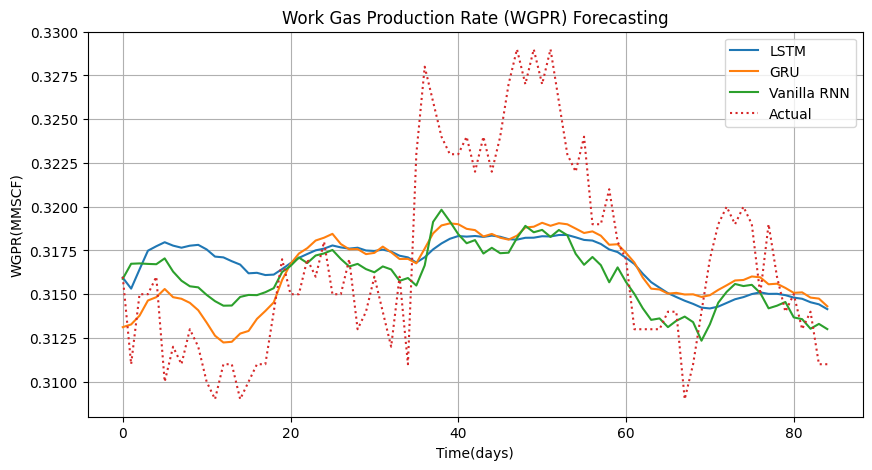

In [15]:

# Plot the predicted and actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(Y_pred_test_LSTM, label='LSTM')
plt.plot(Y_pred_test_GRU, label='GRU')
plt.plot(Y_pred_test_RNN, label='Vanilla RNN')
plt.plot(Y_test_act, label='Actual', ls= "dotted")
plt.title('Work Gas Production Rate (WGPR) Forecasting')
plt.xlabel('Time(days)')
plt.ylabel('WGPR(MMSCF)')
plt.grid(True)
plt.legend()
plt.show()



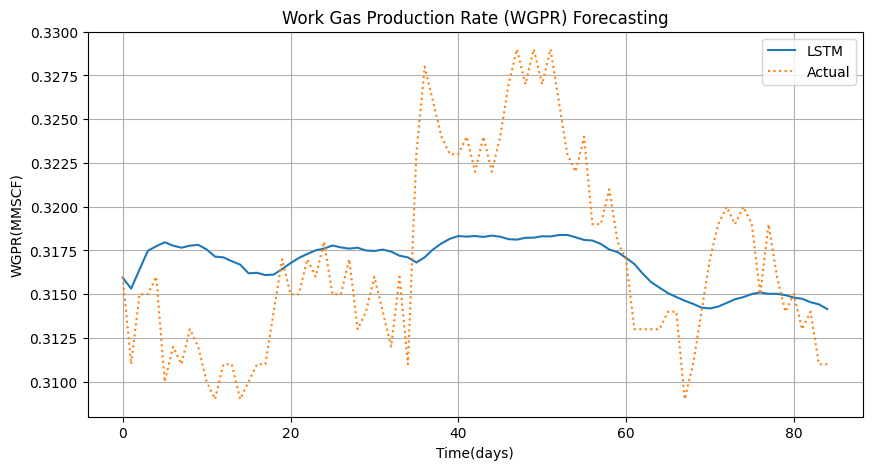

In [16]:
plt.figure(figsize=(10,5))
plt.plot(Y_pred_test_LSTM, label='LSTM')
plt.plot(Y_test_act, label='Actual', ls= "dotted")
plt.title('Work Gas Production Rate (WGPR) Forecasting')
plt.xlabel('Time(days)')
plt.ylabel('WGPR(MMSCF)')
plt.grid(True)
plt.legend()
plt.show()


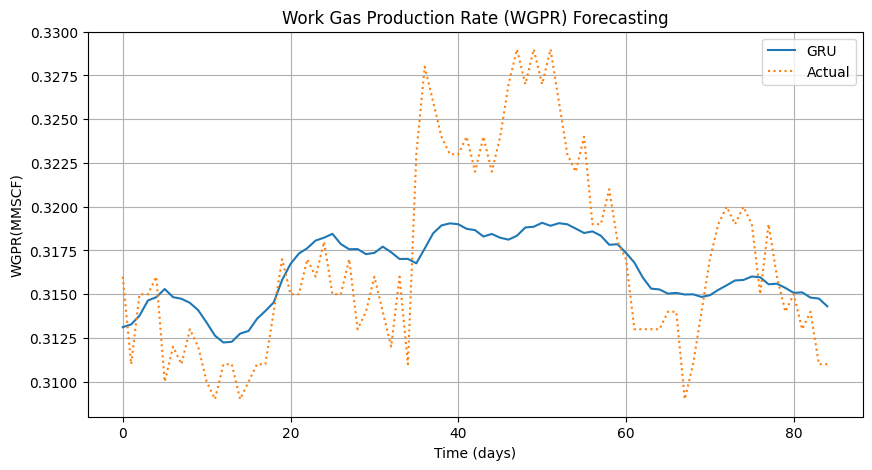

In [17]:
plt.figure(figsize=(10,5))

plt.plot(Y_pred_test_GRU, label='GRU')
plt.plot(Y_test_act, label='Actual', ls= "dotted")
plt.title('Work Gas Production Rate (WGPR) Forecasting')
plt.xlabel('Time (days)')
plt.ylabel('WGPR(MMSCF)')
plt.grid(True)
plt.legend()
plt.show()


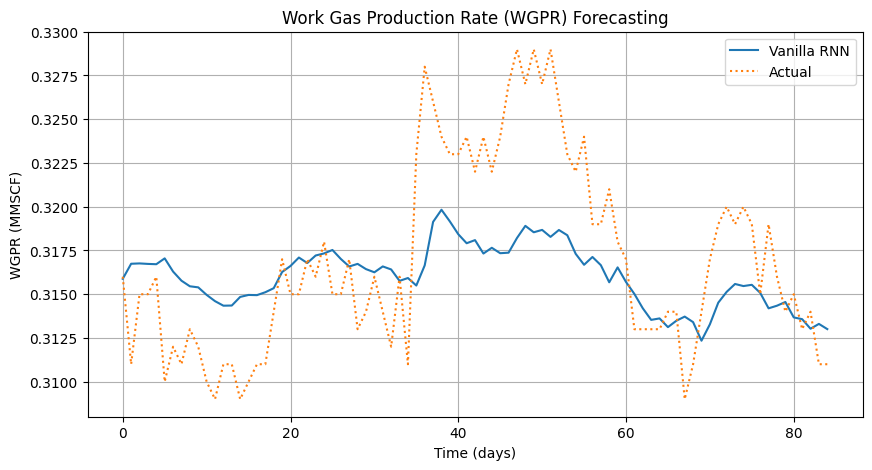

In [18]:
plt.figure(figsize=(10,5))

plt.plot(Y_pred_test_RNN, label='Vanilla RNN')
plt.plot(Y_test_act, label='Actual', ls= "dotted")
plt.title('Work Gas Production Rate (WGPR) Forecasting')
plt.xlabel('Time (days)')
plt.ylabel('WGPR (MMSCF)')
plt.grid(True)
plt.legend()
plt.show()


In [19]:
'''
train_mse=mean_squared_error(Y_train, Y_pred_LSTM)
dev_mse=mean_squared_error(Y_dev, Y_pred_LSTM)
'''
test_mse=mean_squared_error(Y_test_act, Y_pred_test_LSTM)
'''
train_mse_GRU=mean_squared_error(Y_train, Y_pred_GRU)
dev_mse_GRU=mean_squared_error(Y_dev, Y_pred_GRU)
'''
test_mse_GRU=mean_squared_error(Y_test_act, Y_pred_test_GRU)
'''
train_mse_RNN=mean_squared_error(Y_train, Y_pred_Vanilla)
dev_mse_RNN=mean_squared_error(Y_dev, Y_pred_Vanilla)
'''
test_mse_RNN=mean_squared_error(Y_test_act, Y_pred_test_RNN)
'''
print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
'''
print('Test Set MSE_LSTM: %1.4f' % test_mse)
'''
print('Training Set MSE: %1.4f' % train_mse_GRU)
print('Dev Set MSE: %1.4f' % dev_mse_GRU)
'''
print('Test Set MSE_GRU: %1.4f' % test_mse_GRU)
'''
print('Training Set MSE: %1.4f' % train_mse_RNN)
print('Dev Set MSE: %1.4f' % dev_mse_RNN)
'''
print('Test Set MSE_VanillaRNN: %1.4f' % test_mse_RNN)

Test Set MSE_LSTM: 0.0000
Test Set MSE_GRU: 0.0000
Test Set MSE_VanillaRNN: 0.0000


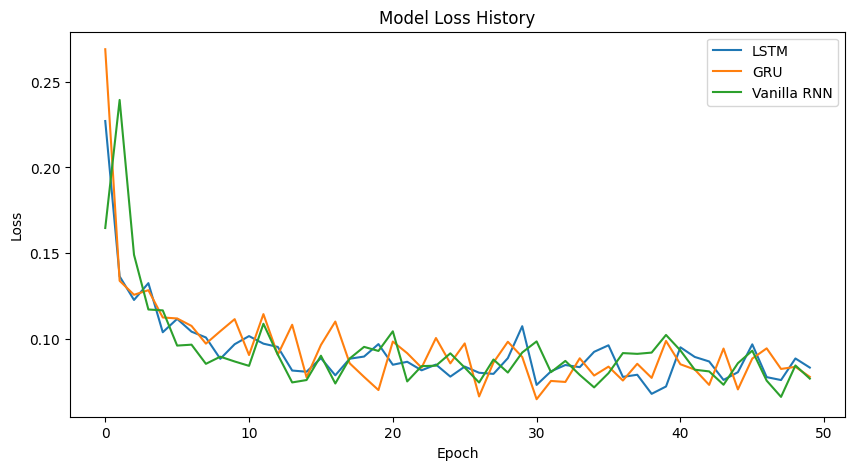

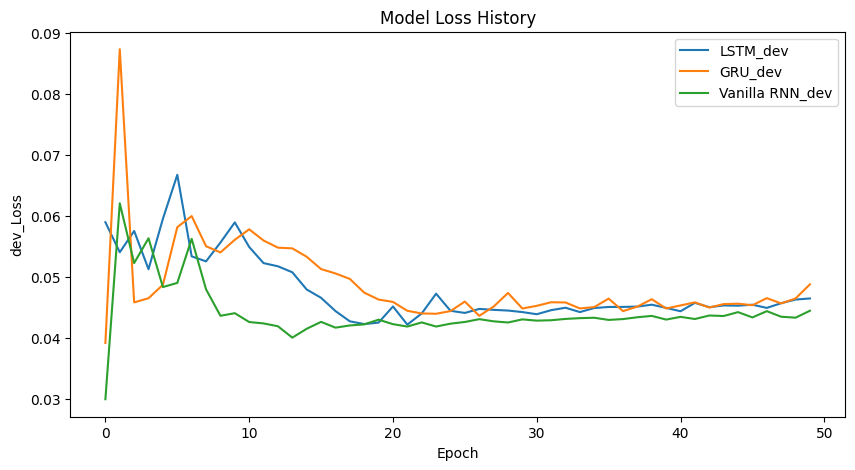

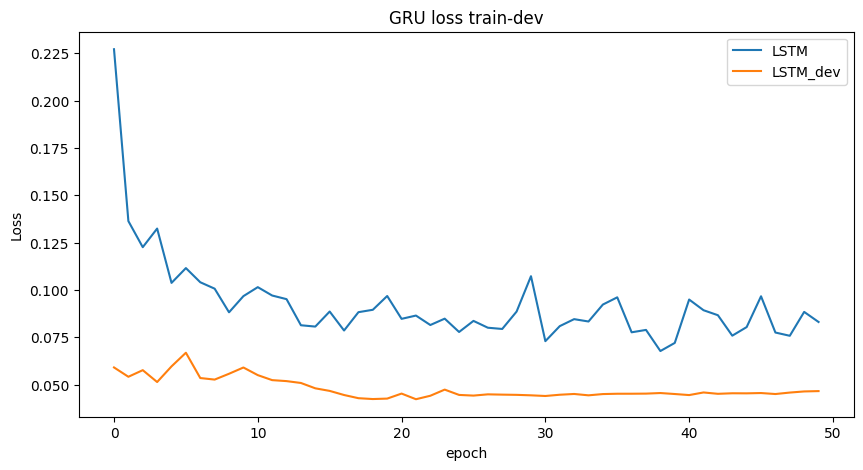

In [20]:
# Plot the loss history of each model
plt.figure(figsize=(10,5))
plt.plot(history_LSTM.history['loss'], label='LSTM')
plt.plot(history_GRU.history['loss'], label='GRU')
plt.plot(history_Vanilla.history['loss'], label='Vanilla RNN')
plt.title('Model Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history_LSTM.history['val_loss'], label='LSTM_dev')
plt.plot(history_GRU.history['val_loss'], label='GRU_dev')
plt.plot(history_Vanilla.history['val_loss'], label='Vanilla RNN_dev')
plt.title('Model Loss History')
plt.xlabel('Epoch')
plt.ylabel('dev_Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history_LSTM.history['loss'], label='LSTM')
plt.plot(history_LSTM.history['val_loss'], label ='LSTM_dev')
plt.title('GRU loss train-dev')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()